# **SMU Course Bidding Prediction Using CatBoost V3**

<h2><span style="color:red">NOTE: use at your own descretion.</span></h2>

### **Changes in V3**
- Replaced `BidderCount` with `Before Process Vacancy` due to future dependent results like `After Process Vacancy` which is not available at prediction time.
- Development of two models, one for `Median Bid Price` and `Min Bid Price`.
- Refined model input to make ingesting data for prediction easier. No label encoding done for `Term` or `Round`.

### **Objective**
This notebook predicts the minimum bid required for courses in the SMU bidding system using a **CatBoost** regression model. Building on the insights gained from **V1 & V2**, this version incorporates **additional data columns** that may influence bid prices, improving the model's predictive power and interpretability. Additionally, this version creates two models:
1. Median Bid Prices prediction
2. Min Bid Prices prediction

### **Key Enhancements in V3**

**Learning from V1:**
   - V1 relied solely on data readily available from BOSS.
   - V2 incorporates **scraped data** from the BOSS Bidding website, adding features like:
     - **Class timings** (days, start times, venues).
     - **Exam schedules** (dates, start times, and days).
     - **Grading basis** (e.g., graded or pass/fail).
   - V2 additionally has outliers removed already in V2_03_SMU_Bidding_Preprocessing.ipynb

**Learning from V2:**
   - V2 had `BidderCount` which was future dependent. Although it was helpful in identifying supply demand, it may inadvertently provide poor results. Thus it is removed.
   - Median Bid Prices may be easier to predict since it is more consistent than min bid prices. Thus, there may be value to using both to understand the estimated range of bids.



### **Updated Dataset Columns**

| **Column Name**                | **Description** |
|--------------------------------|-----------------------------------------------------------|
| **`Term`**                     | Academic term of the course (1, 2, 3A or 3B). |
| **`Description`**              | Name of the course. |
| **`Section`**                  | Course section identifier. |
| **`Vacancy`**                  | Total available spots in the course. |
| **`Before Process Vacancy`**   | Number of available spots **before** the bidding process. |
| **`Instructor`**               | Name of the instructor. |
| **`Grading Basis`**            | Type of grading (e.g., Graded, Pass/Fail). |
| **`class1_day`**               | Day of the week for the first class session. |
| **`class1_starttime`**         | Start time for the first class session. |
| **`class1_venue`**             | Venue for the first class session. |
| **`class2_day`**               | Day of the week for the second class session (if applicable). |
| **`class2_starttime`**         | Start time for the second class session. |
| **`class2_venue`**             | Venue for the second class session. |
| **`class3_day`**               | Day of the week for the third class session (if applicable). |
| **`class3_starttime`**         | Start time for the third class session. |
| **`class3_venue`**             | Venue for the third class session. |
| **`exam_day`**                 | Exam day of the week. |
| **`exam_starttime`**           | Exam start time. |
| **`AY`**                       | Academic year in which the course is offered. |
| **`Incoming Freshman`**        | Whether the course is for incoming freshmen (`yes` or `no`). |
| **`Incoming Exchange`**        | Whether the course is for incoming exchange students (`yes` or `no`). |
| **`Round`**                    | Bidding round (1, 1A, 1B, 1C, 2, 2A). |
| **`Window`**                   | Bidding window within the round (1, 2, 3, 4, 5). |
| **`SubjectArea`**              | Subject area of the course (e.g., IS, ECON). |
| **`CatalogueNo`**              | Course code (e.g., 453). |
| **`exam_date`**                | Exam date (extracted from `exam_startdate`). |
| **`exam_month`**               | Exam month (extracted from `exam_startdate`). |
| **🎯 Target Variables 🎯**      | **Predicted bid prices** |
| **`Min Bid`**                  | Minimum bid price required for the course. |
| **`Median Bid`**               | Median bid price required for the course. |

### **Methodology**
The notebook is structured as follows:

1. **Data Preparation**:
   - Loading and cleaning data.
   - Standardizing data types.
   - Splitting data into train and test sets.
2. **Model Development**:
   - Training a baseline CatBoost model with tuned parameters.
   - Evaluating the model using **Mean Squared Log Error (MSLE)**.
3. **Safety Factors and Analysis**:
   - Experimenting with safety factors to improve TP rate.
4. **Feature Importance**:
   - Using CatBoost's internal feature importance metrics for insights.
5. **Bootstrap-based Confidence Interval**:
   - Provide sample prediction
   - Retrain model on samples of training data and predict.
6. **Conclusion**:
   - Summarizing findings.
   - Identifying next steps for improvement.

### **Note**
To run this notebook:
- Ensure `catboost` is installed: `pip install catboost`.
- Include the required dataset (`transformed_data_w_timings.csv`).

This version aims to provide a more comprehensive analysis of factors influencing bid prices by leveraging richer data.

---

## **1. Data Preparation**

### **1.1 Loading the Data**
- Import necessary libraries.
- Load the dataset and display its structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
import scipy.stats as stats

In [2]:
# Load data
# Load data without interpreting 'NA' as NaN
data = pd.read_csv(
    'transformed_data_w_timings_v3.csv',  # File path
    keep_default_na=False              # Prevent automatic conversion of 'NA' to NaN
)
print("Data Shape:", data.shape)
display(data.head())

Data Shape: (35734, 28)


C:\Users\tanzh\AppData\Local\Temp\ipykernel_23748\1738184617.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


,Term,Description,Section,Vacancy,Before Process Vacancy,Median Bid,Min Bid,Instructor,Grading Basis,class1_day,...,exam_startdate,exam_day,exam_starttime,AY,Incoming Freshman,Incoming Exchange,Round,Window,SubjectArea,CatalogueNo
0,2,Financial Reporting and Analysis,G3,42,3,25.00,25.00,GOH BENG WEE,Graded,Wed,...,20-Apr-2022,Wed,08:30,2021,no,no,2A,3,ACCT,224
1,2,Valuation,G1,42,9,10.09,10.09,CHENG NAM SANG,Graded,Mon,...,27-Apr-2022,Wed,08:30,2021,no,no,2A,3,ACCT,336
2,2,Valuation,G2,42,12,10.03,10.00,CHENG NAM SANG,Graded,Mon,...,27-Apr-2022,Wed,08:30,2021,no,no,2A,3,ACCT,336
3,2,Auditing for the Public Sector,G1,42,7,25.00,25.00,LIM SOO PING,Graded,Thu,...,27-Apr-2022,Wed,13:00,2021,no,no,2A,3,ACCT,409
4,2,Public Relations Writing,G1,45,10,10.00,10.00,YASMIN HANNAH RAMLE,Graded,Thu,...,NA,NA,NA,2021,no,no,2A,3,COMM,225


### **1.2 Standardizing Data Types**
- Ensure proper data types for numeric and categorical columns.

In [3]:
# Ensure proper data types for all columns
def standardise_data_types(data):
    # Ensure categorical columns are properly typed

    categorical_cols = [
        'Term','Description','Section',
        'Instructor','Grading Basis','class1_day','class1_starttime','class1_venue',
        'class2_day','class2_starttime','class2_venue','class3_day','class3_starttime',
        'class3_venue','exam_startdate','exam_day','exam_starttime',
        'Incoming Freshman','Incoming Exchange','Round','SubjectArea','CatalogueNo'
    ]
    for col in categorical_cols:
        data[col] = data[col].astype('object')

    # Convert date columns to datetime
    data['exam_startdate'] = pd.to_datetime(data['exam_startdate'], errors='coerce')

    # Extract year and month from `exam_startdate`
    data['exam_date'] = data['exam_startdate'].dt.day
    data['exam_month'] = data['exam_startdate'].dt.month

    # Drop the original `exam_startdate` column
    data = data.drop(columns=['exam_startdate'])

    # Extract year and month from `exam_startdate`
    data['exam_date'] = data['exam_date'].fillna(0).astype(int)
    data['exam_month'] = data['exam_month'].fillna(0).astype(int)

    return data

# Apply standardisation
data = standardise_data_types(data)

In [4]:
data.head(15)

,Term,Description,Section,Vacancy,Before Process Vacancy,Median Bid,Min Bid,Instructor,Grading Basis,class1_day,...,exam_starttime,AY,Incoming Freshman,Incoming Exchange,Round,Window,SubjectArea,CatalogueNo,exam_date,exam_month
0,2,Financial Reporting and Analysis,G3,42,3,25.00,25.00,GOH BENG WEE,Graded,Wed,...,08:30,2021,no,no,2A,3,ACCT,224,20,4
1,2,Valuation,G1,42,9,10.09,10.09,CHENG NAM SANG,Graded,Mon,...,08:30,2021,no,no,2A,3,ACCT,336,27,4
2,2,Valuation,G2,42,12,10.03,10.00,CHENG NAM SANG,Graded,Mon,...,08:30,2021,no,no,2A,3,ACCT,336,27,4
3,2,Auditing for the Public Sector,G1,42,7,25.00,25.00,LIM SOO PING,Graded,Thu,...,13:00,2021,no,no,2A,3,ACCT,409,27,4
4,2,Public Relations Writing,G1,45,10,10.00,10.00,YASMIN HANNAH RAMLE,Graded,Thu,...,NA,2021,no,no,2A,3,COMM,225,0,0
5,2,Designing Communication for Behavioural Change,G1,45,2,10.00,10.00,SUNGJONG ROH,Graded,Tue,...,NA,2021,no,no,2A,3,COMM,302,0,0
6,2,Management Communication,G8,30,3,35.00,35.00,CHAN BOH YEE,NA,NA,...,NA,2021,no,no,2A,3,COR-COMM,1304,0,0
7,2,Japanese,G3,45,2,26.45,26.44,"AKIKO ITO, AKIKO ITO",NA,NA,...,NA,2021,no,no,2A,3,COR-JPAN,2401,0,0
8,2,"Business, Government and Society",G3,45,5,25.00,25.00,CHAN KAY MIN,NA,NA,...,NA,2021,no,no,2A,3,COR-MGMT,1302,0,0
9,2,Spreadsheet Modeling and Analytics,G13,40,8,40.00,40.00,KARTHIKEYAN KANNAN,Graded,Wed,...,08:30,2021,no,no,2A,3,COR,1305,20,4


### **1.3 Train-Test Split**
- Split the dataset into training (AY < 2024) and testing (AY = 2024, Term = 1 or 2).

In [5]:
# Define test set as AY=2024 and Term=1
test_mask = (data['AY'] == 2024) & (data['Term'].isin(['1', '2']))
test_data = data[test_mask].copy()
train_data = data[~test_mask].copy()

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (30326, 29)
Test shape: (5408, 29)



---
## **2. Model Development**

### **2.1 Feature Selection**
- Define features, target, and categorical variables.
- Split into two target variables: `Min Bid` and `Median Bid`

In [6]:
target_min_bid = 'Min Bid'
target_median_bid = 'Median Bid'

features = [
    'Term','Description','Section','Vacancy','Before Process Vacancy',
    'Instructor','Grading Basis','class1_day','class1_starttime','class1_venue',
    'class2_day','class2_starttime','class2_venue','class3_day','class3_starttime',
    'class3_venue','exam_day','exam_starttime','AY',
    'Incoming Freshman','Incoming Exchange','Round','Window','SubjectArea','CatalogueNo',
    'exam_date', 'exam_month'
]

# Specify categorical features for CatBoost
cat_features = [
    'Term','Description','Section',
    'Instructor','Grading Basis','class1_day','class1_starttime','class1_venue',
    'class2_day','class2_starttime','class2_venue','class3_day','class3_starttime',
    'class3_venue','exam_day','exam_starttime',
    'Incoming Freshman','Incoming Exchange','Round','SubjectArea','CatalogueNo'
]

X_train = train_data[features]
y_train_min_bid = train_data[target_min_bid]
y_train_median_bid = train_data[target_median_bid]

X_test = test_data[features]
y_test_min_bid = test_data[target_min_bid]
y_test_median_bid = test_data[target_median_bid]


---
### **2.2 Training the Model**
- Train a CatBoost model with tuned model parameters from V1.
- Create two models:
    1. `model_min_bid` - predict min prices.
    2. `model_median_bid` - predict median prices.

#### model_min_bid

In [7]:
model_min_bid = CatBoostRegressor(
    bagging_temperature= 1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False)
model_min_bid.fit(X_train, y_train_min_bid)

#### model_median_bid

In [8]:
model_median_bid = CatBoostRegressor(
    bagging_temperature= 1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False)
model_median_bid.fit(X_train, y_train_median_bid)


---
### **2.3 Predictions and Metrics**
**MSLE (Mean Squared Log Error)**
- Measures relative error, penalising underestimations.

**MAE (Mean Absolute Error)**
- Measures absolute difference regardless of direction.

**R Sqaure**
- Proportion of variance in dependent variable explained by independent variables.

#### model_min_bid

In [9]:
# Get predictions
y_pred_min_bid = model_min_bid.predict(X_test)

# Compute MSLE
msle_value_min_bid = mean_squared_log_error(y_test_min_bid, y_pred_min_bid)
print("Min Bid Model MSLE:", msle_value_min_bid)

# Compute MSLE
mae_value_min_bid = mean_absolute_error(y_test_min_bid, y_pred_min_bid)
print("Min Bid Model MAE:", mae_value_min_bid)

# Compute R2 score
r2_value_min_bid = r2_score(y_test_min_bid, y_pred_min_bid)
print("Min Bid Model R2:", r2_value_min_bid)

Min Bid Model MSLE: 0.18421654225054515
Min Bid Model MAE: 8.281312804861217
Min Bid Model R2: 0.42747477252563837


In [10]:
# Calculate errors
errors_min_bid = y_pred_min_bid - y_test_min_bid

# Compute mean and standard deviation of errors
mean_error_min_bid = np.mean(errors_min_bid)
std_error_min_bid = np.std(errors_min_bid)

# Compute 2.5th and 97.5th percentiles for the error distribution
percentile_2_5_min_bid = np.percentile(errors_min_bid, 2.5)
percentile_97_5_min_bid = np.percentile(errors_min_bid, 97.5)

# Print values
print(f"2.5th percentile: {percentile_2_5_min_bid:.2f}")
print(f"97.5th percentile: {percentile_97_5_min_bid:.2f}")
print(f"Mean error: {mean_error_min_bid:.2f}")
print(f"Std error: {std_error_min_bid:.2f}")

# Generate values for normal distribution curve
x_values_min_bid = np.linspace(min(errors_min_bid), max(errors_min_bid), 100)
y_values_min_bid = stats.norm.pdf(x_values_min_bid, mean_error_min_bid, std_error_min_bid) * len(errors_min_bid) * (max(errors_min_bid) - min(errors_min_bid)) / 50

2.5th percentile: -25.02
97.5th percentile: 19.51
Mean error: 0.07
Std error: 11.28


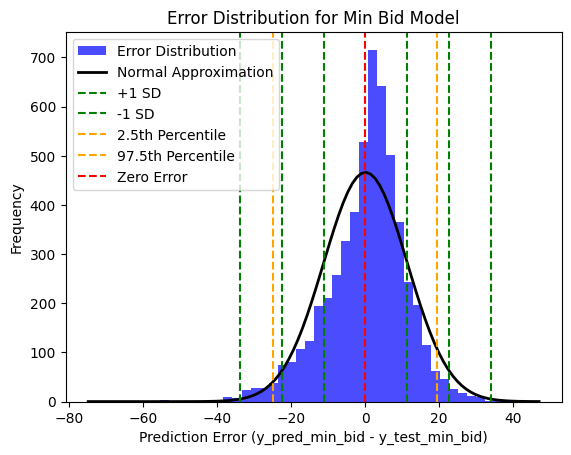

In [11]:
# Plot histogram of errors
plt.hist(errors_min_bid, bins=50, alpha=0.7, color='blue', density=False, label="Error Distribution")

# Plot normal distribution curve
plt.plot(x_values_min_bid, y_values_min_bid, color='black', linestyle='-', linewidth=2, label="Normal Approximation")

# Add vertical lines for standard deviations
for i in range(1, 4):
    plt.axvline(mean_error_min_bid + i * std_error_min_bid, color='green', linestyle='--', label=f'+{i} SD' if i == 1 else None)
    plt.axvline(mean_error_min_bid - i * std_error_min_bid, color='green', linestyle='--', label=f'-{i} SD' if i == 1 else None)

# Add vertical lines for percentiles
plt.axvline(percentile_2_5_min_bid, color='orange', linestyle='--', label='2.5th Percentile')
plt.axvline(percentile_97_5_min_bid, color='orange', linestyle='--', label='97.5th Percentile')

# Labels and title
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred_min_bid - y_test_min_bid)')
plt.ylabel('Frequency')
plt.title('Error Distribution for Min Bid Model')
plt.legend()
plt.show()

#### model_median_bid

In [12]:
# Get predictions
y_pred_median_bid = model_median_bid.predict(X_test)

# Compute MSLE
msle_value_median_bid = mean_squared_log_error(y_test_median_bid, y_pred_median_bid)
print("Median Bid Model MSLE:", msle_value_median_bid)

# Compute MSLE
mae_value_median_bid = mean_absolute_error(y_test_median_bid, y_pred_median_bid)
print("Median Bid Model MAE:", mae_value_median_bid)

# Compute R2 score
r2_value_median_bid = r2_score(y_test_median_bid, y_pred_median_bid)
print("Median Bid Model R2:", r2_value_median_bid)

Median Bid Model MSLE: 0.16157290784609113
Median Bid Model MAE: 8.618287856720613
Median Bid Model R2: 0.43638661043944615


In [13]:
# Calculate errors
errors_median_bid = y_pred_median_bid - y_test_median_bid

# Compute mean and standard deviation of errors
mean_error_median_bid = np.mean(errors_median_bid)
std_error_median_bid = np.std(errors_median_bid)

# Compute 2.5th and 97.5th percentiles for the error distribution
percentile_2_5_median_bid = np.percentile(errors_median_bid, 2.5)
percentile_97_5_median_bid = np.percentile(errors_median_bid, 97.5)

# Print values
print(f"2.5th percentile: {percentile_2_5_median_bid:.2f}")
print(f"97.5th percentile: {percentile_97_5_median_bid:.2f}")
print(f"Mean error: {mean_error_median_bid:.2f}")
print(f"Std error: {std_error_median_bid:.2f}")

# Generate values for normal distribution curve
x_values_median_bid = np.linspace(min(errors_median_bid), max(errors_median_bid), 100)
y_values_median_bid = stats.norm.pdf(x_values_median_bid, mean_error_median_bid, std_error_median_bid) * len(errors_median_bid) * (max(errors_median_bid) - min(errors_median_bid)) / 50

2.5th percentile: -26.06
97.5th percentile: 21.24
Mean error: 0.14
Std error: 11.97


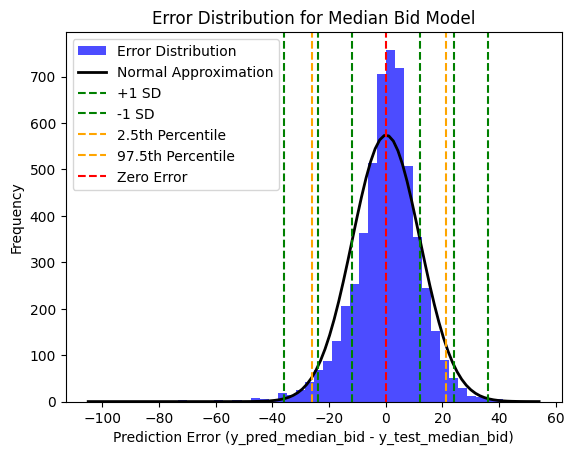

In [14]:
# Plot histogram of errors
plt.hist(errors_median_bid, bins=50, alpha=0.7, color='blue', density=False, label="Error Distribution")

# Plot normal distribution curve
plt.plot(x_values_median_bid, y_values_median_bid, color='black', linestyle='-', linewidth=2, label="Normal Approximation")

# Add vertical lines for standard deviations
for i in range(1, 4):
    plt.axvline(mean_error_median_bid + i * std_error_median_bid, color='green', linestyle='--', label=f'+{i} SD' if i == 1 else None)
    plt.axvline(mean_error_median_bid - i * std_error_median_bid, color='green', linestyle='--', label=f'-{i} SD' if i == 1 else None)

# Add vertical lines for percentiles
plt.axvline(percentile_2_5_median_bid, color='orange', linestyle='--', label='2.5th Percentile')
plt.axvline(percentile_97_5_median_bid, color='orange', linestyle='--', label='97.5th Percentile')

# Labels and title
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred_median_bid - y_test_median_bid)')
plt.ylabel('Frequency')
plt.title('Error Distribution for Median Bid Model')
plt.legend()
plt.show()


---
## **3. Safety Factors and Analysis** 
Experiment with safety factors to improve TP rate. 

#### model_min_bid

Min Bid Model MSLE: 0.18421654225054515
Min Bid Model Initial TPR (no safety factor): 0.09467455621301775


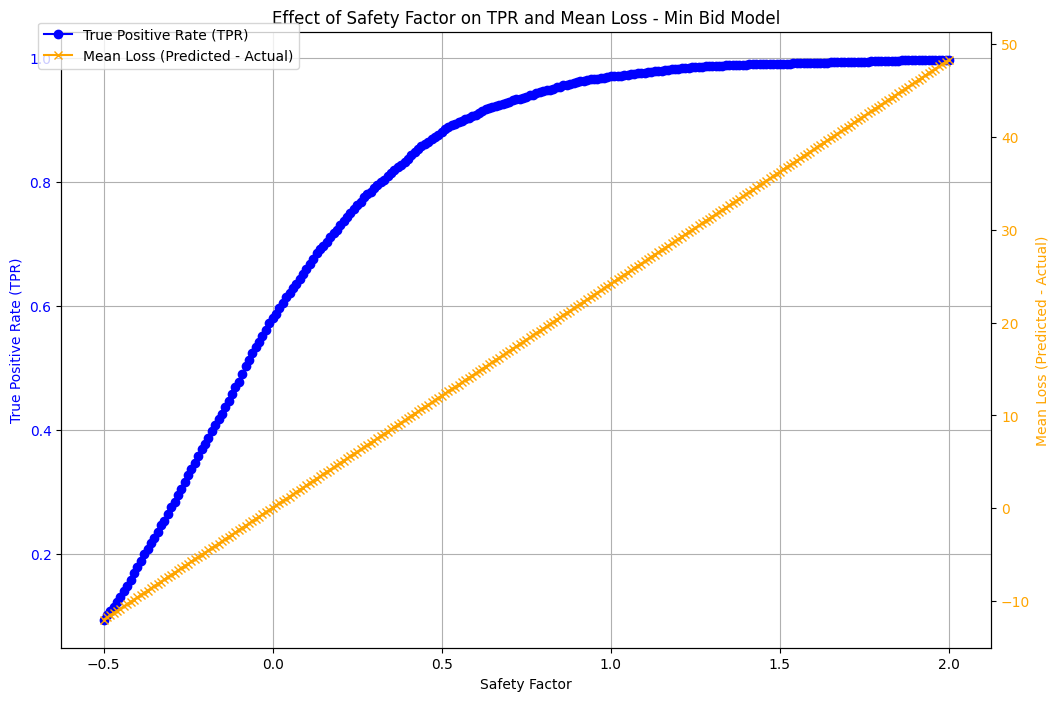

In [15]:
# Initialize lists to store results
safety_factors = np.arange(-0.50, 2.01, 0.01)
tpr_values = []
loss_values = []

# Loop through safety factors
for sf in safety_factors:
    # Apply safety factor to predictions
    adjusted_pred = y_pred_min_bid * (1 + sf)

    # Compute TP Rate
    pred_binary = (adjusted_pred >= y_test_min_bid).astype(int)
    tp_rate = pred_binary.mean()

    # Compute Mean Loss (average difference between predicted and actual)
    mean_loss = np.mean(adjusted_pred - y_test_min_bid)

    # Store TPR and Loss
    tpr_values.append(tp_rate)
    loss_values.append(mean_loss)

# Print MSLE and initial TPR (without safety factor)
print("Min Bid Model MSLE:", msle_value_min_bid)
print("Min Bid Model Initial TPR (no safety factor):", tpr_values[0])

# Plot TPR and Mean Loss with Dual Y-Axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot TPR on the left y-axis
ax1.plot(safety_factors, tpr_values, marker='o', color='blue', label='True Positive Rate (TPR)')
ax1.set_xlabel('Safety Factor')
ax1.set_ylabel('True Positive Rate (TPR)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Effect of Safety Factor on TPR and Mean Loss - Min Bid Model')
ax1.grid(True)

# Plot Mean Loss on the right y-axis
ax2 = ax1.twinx()
ax2.plot(safety_factors, loss_values, marker='x', color='orange', label='Mean Loss (Predicted - Actual)')
ax2.set_ylabel('Mean Loss (Predicted - Actual)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend for clarity
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [16]:
# Convert safety factor list to a NumPy array for easier indexing
safety_factors = np.arange(-0.50, 2.01, 0.01)

# Find the best safety factor based on maximizing TPR while minimizing loss
# Define an optimality criterion: maximize TPR while keeping loss close to zero or minimal

# Convert lists to NumPy arrays
tpr_values = np.array(tpr_values)
loss_values = np.array(loss_values)

# Define a balance factor (weights between TPR and loss minimization)
alpha = 0.7  # Weight for TPR importance (can be tuned)
beta = 0.3   # Weight for minimizing loss

# Normalize values for fair comparison
tpr_normalized = (tpr_values - np.min(tpr_values)) / (np.max(tpr_values) - np.min(tpr_values))
loss_normalized = (loss_values - np.min(loss_values)) / (np.max(loss_values) - np.min(loss_values))

# Compute a combined score (higher is better)
optimality_score = alpha * tpr_normalized - beta * np.abs(loss_normalized)

# Find the index of the best safety factor
best_index = np.argmax(optimality_score)
best_safety_factor = safety_factors[best_index]
best_tpr = tpr_values[best_index]
best_loss = loss_values[best_index]

# Print the best safety factor details
print(f"Best Safety Factor: {best_safety_factor:.2f}")
print(f"Corresponding TPR: {best_tpr:.2f}")
print(f"Corresponding Mean Loss: {best_loss:.2f}")

Best Safety Factor: 0.80
Corresponding TPR: 0.95
Corresponding Mean Loss: 19.36


#### model_median_bid

Median Bid Model MSLE: 0.16157290784609113
Median Bid Model Initial TPR (no safety factor): 0.08413461538461539


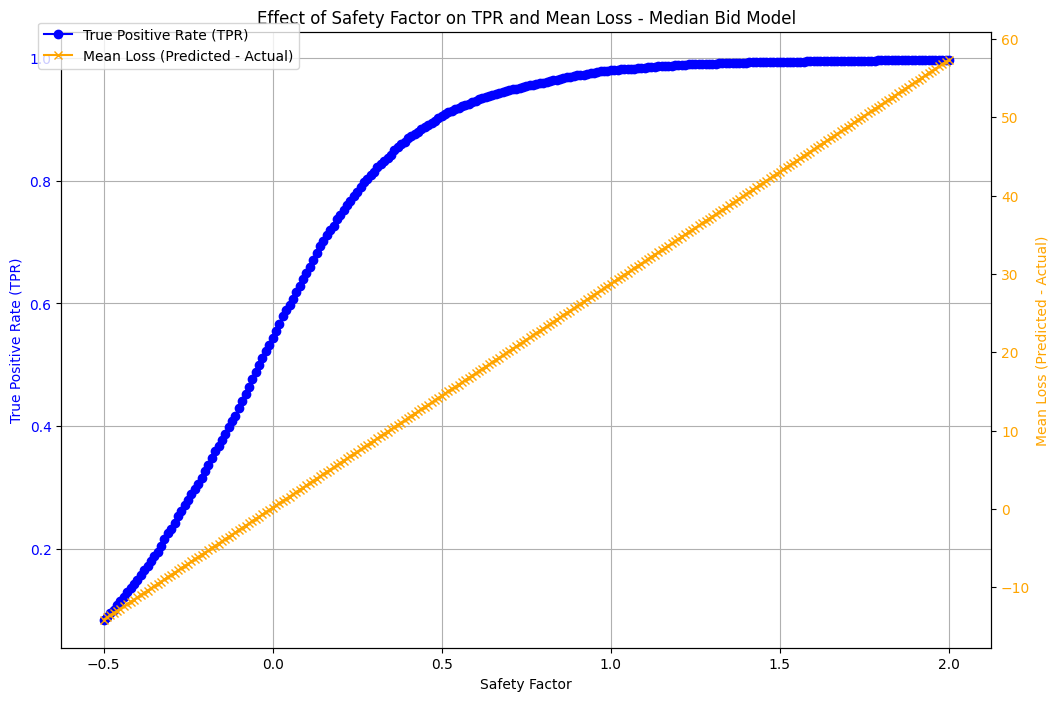

In [17]:
# Initialize lists to store results
safety_factors = np.arange(-0.50, 2.01, 0.01)
tpr_values = []
loss_values = []

# Loop through safety factors
for sf in safety_factors:
    # Apply safety factor to predictions
    adjusted_pred = y_pred_median_bid * (1 + sf)

    # Compute TP Rate
    pred_binary = (adjusted_pred >= y_test_median_bid).astype(int)
    tp_rate = pred_binary.mean()

    # Compute Mean Loss (average difference between predicted and actual)
    mean_loss = np.mean(adjusted_pred - y_test_median_bid)

    # Store TPR and Loss
    tpr_values.append(tp_rate)
    loss_values.append(mean_loss)

# Print MSLE and initial TPR (without safety factor)
print("Median Bid Model MSLE:", msle_value_median_bid)
print("Median Bid Model Initial TPR (no safety factor):", tpr_values[0])

# Plot TPR and Mean Loss with Dual Y-Axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot TPR on the left y-axis
ax1.plot(safety_factors, tpr_values, marker='o', color='blue', label='True Positive Rate (TPR)')
ax1.set_xlabel('Safety Factor')
ax1.set_ylabel('True Positive Rate (TPR)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Effect of Safety Factor on TPR and Mean Loss - Median Bid Model')
ax1.grid(True)

# Plot Mean Loss on the right y-axis
ax2 = ax1.twinx()
ax2.plot(safety_factors, loss_values, marker='x', color='orange', label='Mean Loss (Predicted - Actual)')
ax2.set_ylabel('Mean Loss (Predicted - Actual)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend for clarity
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [18]:
# Convert safety factor list to a NumPy array for easier indexing
safety_factors = np.arange(-0.50, 2.01, 0.01)

# Find the best safety factor based on maximizing TPR while minimizing loss
# Define an optimality criterion: maximize TPR while keeping loss close to zero or minimal

# Convert lists to NumPy arrays
tpr_values = np.array(tpr_values)
loss_values = np.array(loss_values)

# Define a balance factor (weights between TPR and loss minimization)
alpha = 0.7  # Weight for TPR importance (can be tuned)
beta = 0.3   # Weight for minimizing loss

# Normalize values for fair comparison
tpr_normalized = (tpr_values - np.min(tpr_values)) / (np.max(tpr_values) - np.min(tpr_values))
loss_normalized = (loss_values - np.min(loss_values)) / (np.max(loss_values) - np.min(loss_values))

# Compute a combined score (higher is better)
optimality_score = alpha * tpr_normalized - beta * np.abs(loss_normalized)

# Find the index of the best safety factor
best_index = np.argmax(optimality_score)
best_safety_factor = safety_factors[best_index]
best_tpr = tpr_values[best_index]
best_loss = loss_values[best_index]

# Print the best safety factor details
print(f"Best Safety Factor: {best_safety_factor:.2f}")
print(f"Corresponding TPR: {best_tpr:.2f}")
print(f"Corresponding Mean Loss: {best_loss:.2f}")

Best Safety Factor: 0.66
Corresponding TPR: 0.94
Corresponding Mean Loss: 19.02



---
## **4. Feature Importance** 
Top features contributing to prediction

#### model_min_bid

                   Feature  Importance
4   Before Process Vacancy   13.679426
21                   Round   12.925604
1              Description   11.106576
24             CatalogueNo    7.924485
5               Instructor    7.436674
23             SubjectArea    7.207288
2                  Section    5.273774
16                exam_day    3.857475
9             class1_venue    3.784057
0                     Term    3.636247
22                  Window    3.425929
18                      AY    3.015613
6            Grading Basis    2.775049
7               class1_day    2.380974
17          exam_starttime    2.368506
8         class1_starttime    2.258096
3                  Vacancy    1.917271
25               exam_date    1.091215
11        class2_starttime    0.835994
19       Incoming Freshman    0.626767
26              exam_month    0.536324
10              class2_day    0.429892
12            class2_venue    0.413638
14        class3_starttime    0.413275
13              class3_da

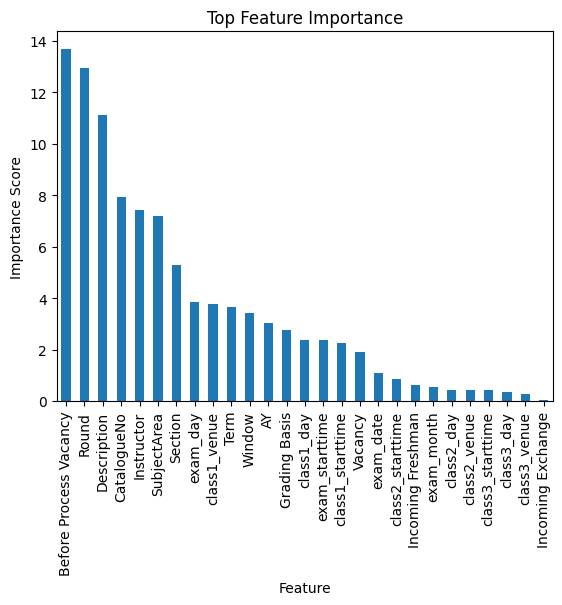

In [19]:
# Use model's internal feature names
features = model_min_bid.feature_names_

# Get feature importance scores
feature_importance = model_min_bid.get_feature_importance(type='FeatureImportance')

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top features
top_features = importance_df
print(top_features)

# Visualize feature importance
top_features.plot(kind='bar', x='Feature', y='Importance', legend=False, title="Top Feature Importance")
plt.ylabel("Importance Score")
plt.show()

#### model_median_bid

                   Feature  Importance
21                   Round   13.448039
4   Before Process Vacancy   13.205794
1              Description   11.788207
24             CatalogueNo    7.573357
23             SubjectArea    7.082556
5               Instructor    6.744695
22                  Window    4.460392
2                  Section    4.184733
9             class1_venue    3.943331
0                     Term    3.724910
8         class1_starttime    2.946178
6            Grading Basis    2.922893
18                      AY    2.922841
17          exam_starttime    2.788061
16                exam_day    2.625293
3                  Vacancy    2.471337
7               class1_day    2.269240
25               exam_date    1.525612
19       Incoming Freshman    0.789327
15            class3_venue    0.557622
11        class2_starttime    0.530650
26              exam_month    0.354721
13              class3_day    0.346935
10              class2_day    0.327878
12            class2_venu

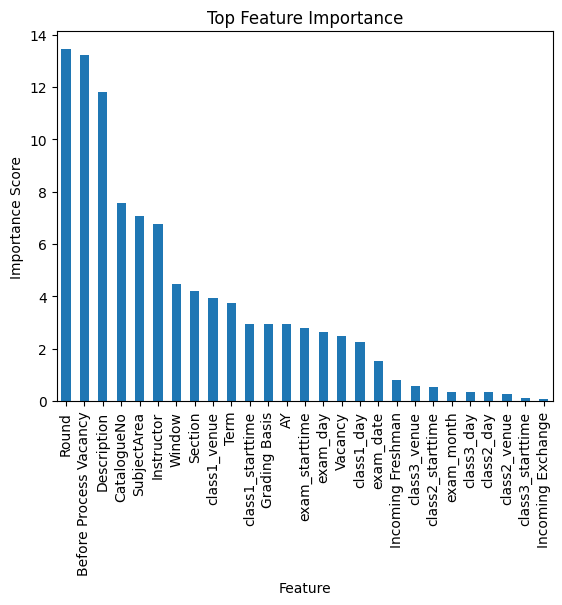

In [20]:
# Use model's internal feature names
features = model_median_bid.feature_names_

# Get feature importance scores
feature_importance = model_median_bid.get_feature_importance(type='FeatureImportance')

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top features
top_features = importance_df
print(top_features)

# Visualize feature importance
top_features.plot(kind='bar', x='Feature', y='Importance', legend=False, title="Top Feature Importance")
plt.ylabel("Importance Score")
plt.show()


---
## **5. Sample prediction**
Test the models using a given example.

In [21]:
# Define the new data instance
new_data = pd.DataFrame({
    'Term': [2],
    'Description': ["Enterprise Solution Management"],
    'Section': ["G1"],
    'Vacancy': [40],
    'Before Process Vacancy': [38],
    'Instructor': ["RAFAEL J. BARROS"],
    'Grading Basis': ["Graded"],
    'class1_day': ["Mon"],
    'class1_starttime': ["08:15"],
    'class1_venue': ["SOE/SCIS2 Seminar Room B1-2"],
    'class2_day': ["NA"],
    'class2_starttime': ["NA"],
    'class2_venue': ["NA"],
    'class3_day': ["NA"],
    'class3_starttime': ["NA"],
    'class3_venue': ["NA"],
    'exam_startdate': ["21-Apr-2025"], 
    'exam_day': ["Mon"],
    'exam_starttime': ["13:00"],
    'AY': [2024],
    'Incoming Freshman': ["no"],
    'Incoming Exchange': ["no"],
    'Round': ["1"],
    'Window': [1],
    'SubjectArea': ["IS"],
    'CatalogueNo': ["214"],
})

In [22]:
# Apply preprocessing
new_data_preprocessed = standardise_data_types(new_data)

In [23]:
# Predict Min Bid Price
predicted_min_bid = model_min_bid.predict(new_data_preprocessed)[0]

# Predict Median Bid Price
predicted_median_bid = model_median_bid.predict(new_data_preprocessed)[0]

# Print Results
print(f"Predicted Min Bid: {predicted_min_bid:.2f}")
print(f"Predicted Median Bid: {predicted_median_bid:.2f}")

Predicted Min Bid: 24.65
Predicted Median Bid: 34.79


In [24]:
# Save the trained model to a file
model_min_bid.save_model("catboost_min_bid.cbm", format="cbm")

# Save the second model (for median bid)
model_median_bid.save_model("catboost_median_bid.cbm", format="cbm")


---
## **6. Conclusion**

### **What Can Be Concluded**
1. **Model improvements**:
   - The inclusion of class timings and grading basis marginally improved accuracy.
   - Handling outliers in preprocessing enhanced the model’s ability to generalize.
2. **Insights into Features**:
   - As expected, the **instructor**, **course description**, and **bidding round** were the most influential predictors.
   - Class timings (e.g., morning vs. evening slots) had a noticeable impact on bid prices.
   - However, up to a certain point of top n feature importance, MAE and MSLE performance doesn't improve. Warranting feature selection for the refined model.
3. **Performance of Additional Enhancements**:
   - Safety factors were effective in improving TPR but increased over-predictions.
   - Confidence intervals provided actionable insights for bid recommendations.

### **What to Do Next**
1. **Data Collection**:
   - Collaborate with students to crowdsource individual bid data for richer insights.
2. **Deployment to website**
   - Allowing students to use the model while generating additional insights, adhering to privacy policies.

Thank you for experimenting with me! Hope to develop better models that are more capable of predicting min bid prices!